In [41]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
import sys, os, warnings
warnings.filterwarnings("ignore")
sys.path.append(os.path.abspath(os.path.join('../src')))

from churn.utils import set_seed
from churn.eda import plot_correlation_heatmap

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

set_seed(42)

## Load data

The target column is ``CHURN``.

In [43]:
DATA_PATH = "../data/Train.csv"
TARGET = "CHURN"

df = pd.read_csv(DATA_PATH)
assert TARGET in df.columns, f"Target column '{TARGET}' not found in data."

print(f"Dataset shape: {df.shape}")
display(df.head())

print("\nClass (CHURN) distribution:")
display(df[TARGET].value_counts(normalize=True))

Dataset shape: (2154048, 19)


,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN
0,00000bfd7d50f01092811bc0c8d7b0d6fe7c3596,FATICK,K > 24 month,4250.0,15.0,4251.0,1417.0,17.0,4.0,388.0,46.0,1.0,1.0,2.0,NO,54,On net 200F=Unlimited _call24H,8.0,0
1,00000cb4a5d760de88fecb38e2f71b7bec52e834,NaN,I 18-21 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,4,NaN,NaN,1
2,00001654a9d9f96303d9969d0a4a851714a4bb57,NaN,K > 24 month,3600.0,2.0,1020.0,340.0,2.0,NaN,90.0,46.0,7.0,NaN,NaN,NO,17,On-net 1000F=10MilF;10d,1.0,0
3,00001dd6fa45f7ba044bd5d84937be464ce78ac2,DAKAR,K > 24 month,13500.0,15.0,13502.0,4501.0,18.0,43804.0,41.0,102.0,2.0,NaN,NaN,NO,62,"Data:1000F=5GB,7d",11.0,0
4,000028d9e13a595abe061f9b58f3d76ab907850f,DAKAR,K > 24 month,1000.0,1.0,985.0,328.0,1.0,NaN,39.0,24.0,NaN,NaN,NaN,NO,11,Mixt 250F=Unlimited_call24H,2.0,0



Class (CHURN) distribution:


CHURN
0    0.812453
1    0.187547
Name: proportion, dtype: float64

## Drop features

From our previous inspection:
- ``user_id`` -> Meaningless
- ``ZONE1`` -> 92% missing
- ``ZONE2`` -> ~94% missing
- ``MRG`` -> Only has a single value (`NO`) for all rows, so it does not contain any information.

When a feature has > 90% missing values, it contians very little information. Moreover, imupting such a large proportion would only introduce noise and bias, making the feature meaningless. Lastly, keeping it would only increase the model complexity.

In [44]:
to_drop = ['user_id', 'MRG', 'ZONE1', 'ZONE2']
keep = [col for col in to_drop if col in df.columns]
df1 = df.drop(columns=keep)

print(f"Features after drop: {df1.shape}, dropped {len(keep)} columns: {keep}")

Features after drop: (2154048, 15), dropped 4 columns: ['user_id', 'MRG', 'ZONE1', 'ZONE2']


## Data splitting

Split the data into (train/val/test) with stratification. The splitting is **before** any imputing/encoding/scaling so that all statistics are learned only on the train split, and no data leakage. The data splitting ratio is as follows:
* Train: 70%
* Validation: 15%
* Test: 15%

In [45]:
X = df1.drop(columns=[TARGET])
y = df1[TARGET].astype(int)


X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42)

print("Train shape:", X_train.shape)# Example dataframe: df
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)

Train shape: (1507833, 14)
Validation shape: (323107, 14)
Test shape: (323108, 14)


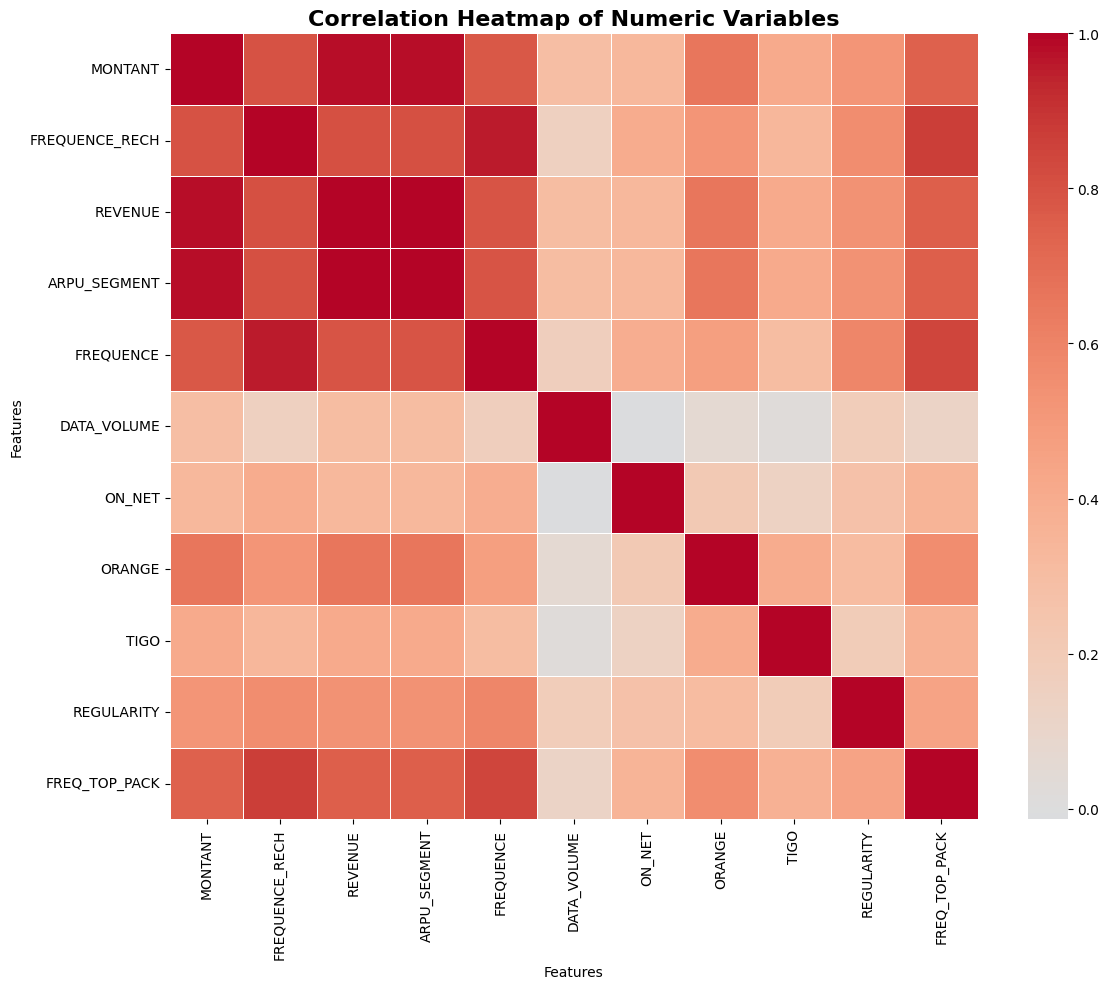

In [46]:
plot_correlation_heatmap(X_train)

In [47]:
X_train = X_train.drop(columns='ARPU_SEGMENT')
X_val = X_val.drop(columns='ARPU_SEGMENT')
X_test = X_test.drop(columns='ARPU_SEGMENT')

X_train.columns

Index(['REGION', 'TENURE', 'MONTANT', 'FREQUENCE_RECH', 'REVENUE', 'FREQUENCE',
       'DATA_VOLUME', 'ON_NET', 'ORANGE', 'TIGO', 'REGULARITY', 'TOP_PACK',
       'FREQ_TOP_PACK'],
      dtype='object')

## Impute numeric features (median)

Numeric features with moderate missingness (30% ~ 49%):
- `MONTANT`, `FREQUENCE_RECH`, `REVENUE`, `ARPU_SEGMENT`, `FREQUENCE`, `DATA_VOLUME`, `ON_NET`, `ORANGE`, `TIGO`, `FREQ_TOP_PACK`

The strategy will be used is the **median** imputation, as it is:
- Robust to outliers.
- Preserves distribution better than mean when heavy tails exist.

In [48]:
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()

X_train_num = X_train[numeric_features].copy()
X_val_num = X_val[numeric_features].copy()
X_test_num = X_test[numeric_features].copy()

for c in numeric_features: 
    med = X_train_num[c].median()
    X_train_num[c] = X_train_num[c].fillna(med)
    X_val_num[c] = X_val_num[c].fillna(med)
    X_test_num[c] = X_test_num[c].fillna(med)

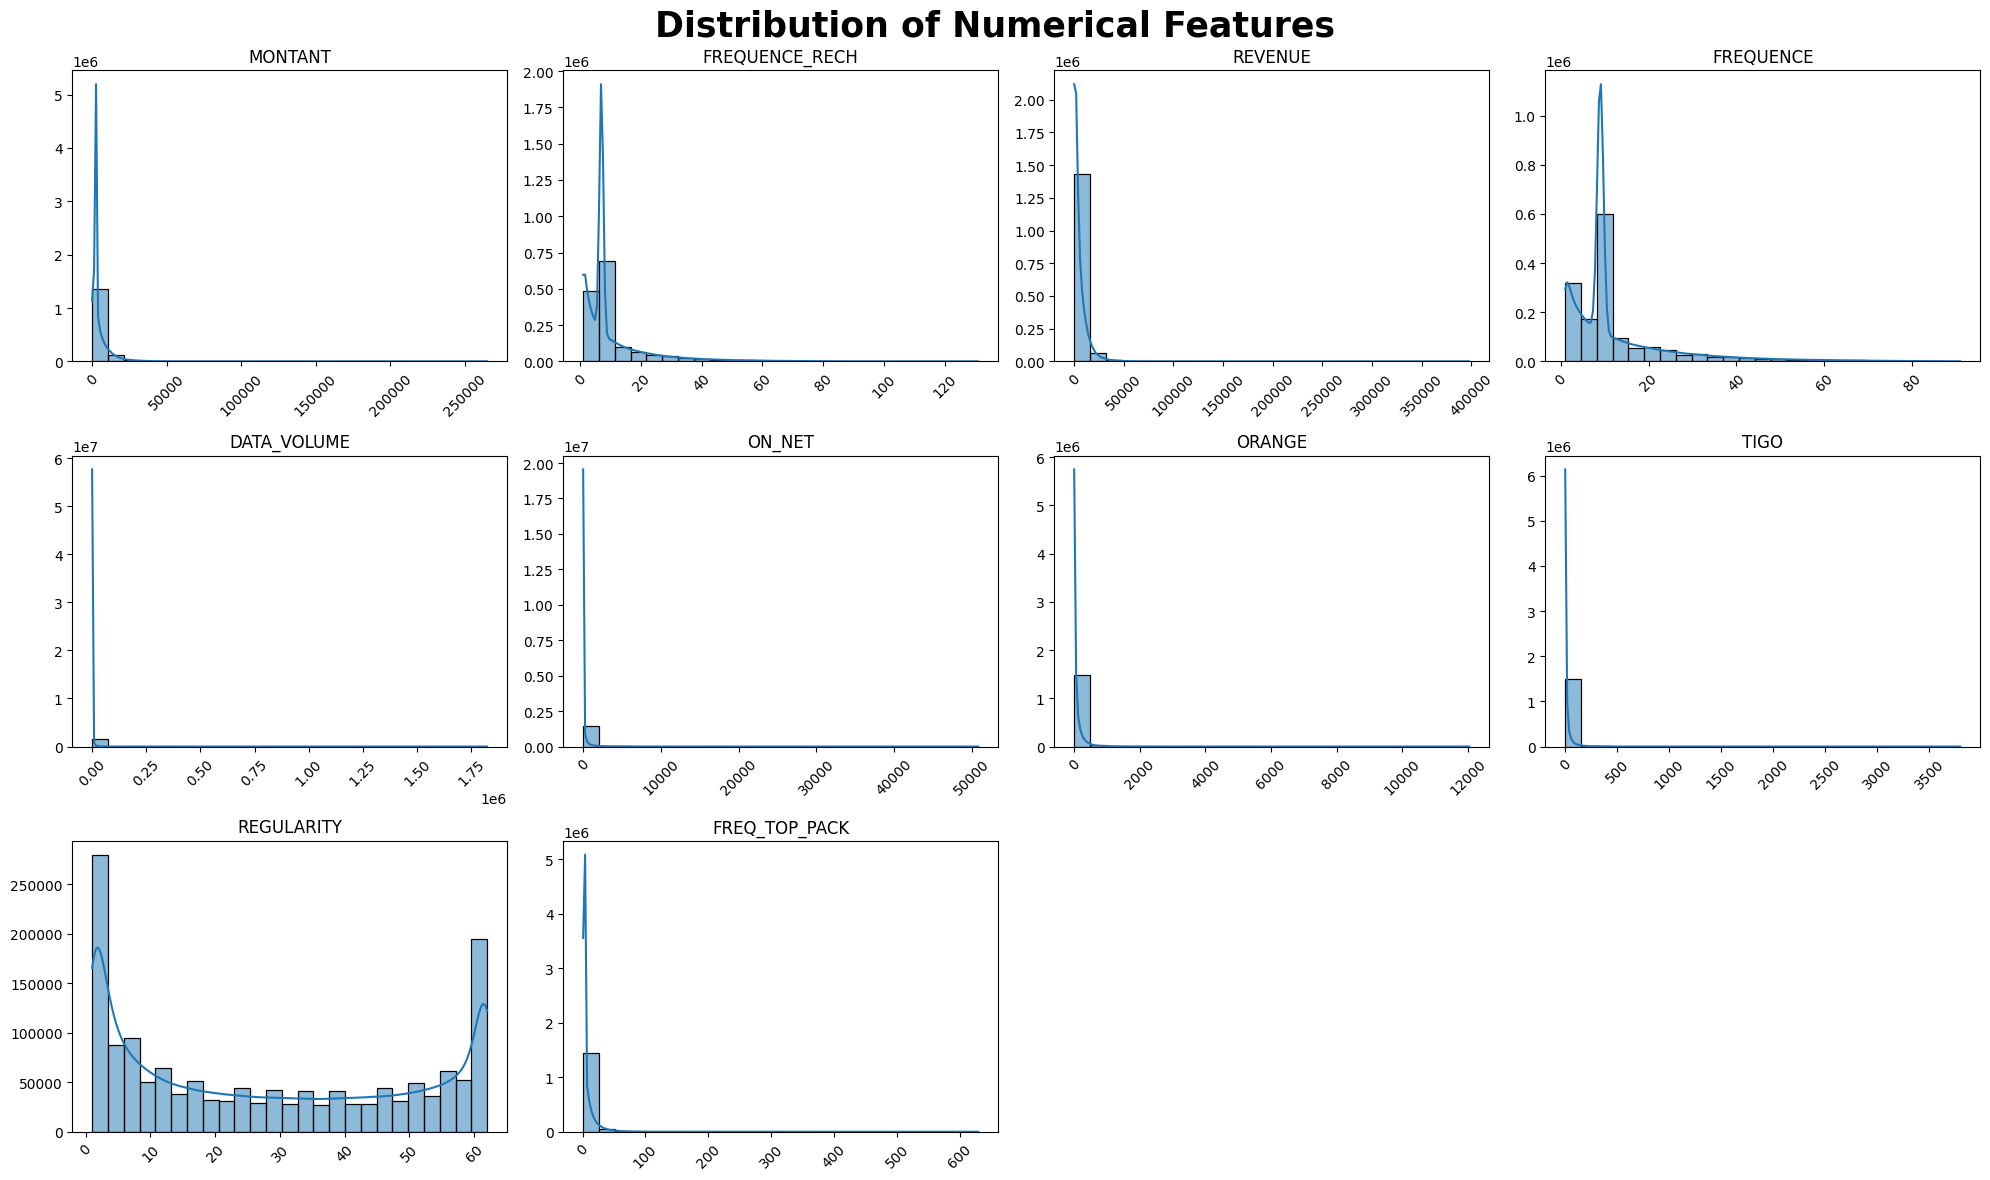

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import math

num_cols = X_train_num.select_dtypes(include=['int64', 'float64']).columns

n = len(num_cols)
rows = 3
cols = math.ceil(n / rows)

plt.figure(figsize=(5 * cols, 4 * rows))

for i, col in enumerate(num_cols, 1):
    plt.subplot(rows, cols, i)
    sns.histplot(X_train_num[col], kde=True, bins=25)
    plt.title(col)
    plt.xticks(rotation=45)
    plt.xlabel("")
    plt.ylabel("")

plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.suptitle("Distribution of Numerical Features", fontsize=25, fontweight="bold")

plt.show()


## Impute categorical features (Unknown)

Categorical features with missing values:
- `REGION` -> ~39% missing 
- `TOP_PACK` -> ~42% missing

The strategy will be used is imputing with **Unknown** category:
- This avoids dropping rows.
- Allows the model to treat the missingness as a distinct category, which can be informative.

In [50]:
categorical_features = ['REGION', 'TOP_PACK', 'TENURE']

X_train_cat = X_train[categorical_features].copy()
X_val_cat   = X_val[categorical_features].copy()
X_test_cat  = X_test[categorical_features].copy()

for c in categorical_features:
    X_train_cat[c] = X_train_cat[c].fillna("Unknown")
    X_val_cat[c]   = X_val_cat[c].fillna("Unknown")
    X_test_cat[c]  = X_test_cat[c].fillna("Unknown")
    
X_train_i = pd.concat([X_train_num, X_train_cat], axis=1)
X_val_i   = pd.concat([X_val_num,   X_val_cat],   axis=1)
X_test_i  = pd.concat([X_test_num,  X_test_cat],  axis=1)

print("After imputation:")
print("Train shape:", X_train_i.shape)
print("Validation shape:", X_val_i.shape)
print("Test shape:", X_test_i.shape)

After imputation:
Train shape: (1507833, 13)
Validation shape: (323107, 13)
Test shape: (323108, 13)


In [51]:
X_train_i = pd.concat([X_train_num, X_train_cat], axis=1)
X_val_i   = pd.concat([X_val_num,   X_val_cat],   axis=1)
X_test_i  = pd.concat([X_test_num,  X_test_cat],  axis=1)

print("After imputation:")
print("Train shape:", X_train_i.shape)
print("Validation shape:", X_val_i.shape)
print("Test shape:", X_test_i.shape)

After imputation:
Train shape: (1507833, 13)
Validation shape: (323107, 13)
Test shape: (323108, 13)


## Ordinal encoding (TENURE)

- `TENURE` -> Ordinal numeric encoding. Tenure represents the range of duration in the network, so it has a natural order (shorter tenure -> higher likelihood of churn). Mapping to numeric values preserves this order and makes it usable in any model later on.

In [52]:
tenure_mapping = {
    'D 3-6 month': 3,
    'E 6-9 month': 6,
    'F 9-12 month': 9,
    'G 12-15 month': 12,
    'H 15-18 month': 15,
    'I 18-21 month': 18,
    'J 21-24 month': 21,
    'K > 24 month': 24,
    'Unknown': 0
}

def encode_categorical(X):
    X = X.copy()
    if "TENURE" in X.columns:
        X['TENURE_NUM'] = X['TENURE'].map(tenure_mapping)
        X.drop(columns=['TENURE'], inplace=True)  
    return X

X_train_t = encode_categorical(X_train_i)
X_val_t   = encode_categorical(X_val_i)
X_test_t  = encode_categorical(X_test_i)    

## Feature Engineering

1. ``REVENUE / MONTANT``: measures efficiency of revenue relative to top-ups. High ratio may indicate high-value customers.
2. ``TENURE / FREQUENCE_RECH``: normalize recharge frequency by how long the customer has been active. Low value may indicate inactivity relative to tenure.
3. ``TENURE / REGULARITY``: shows churn risk relative to engagement. Customers with low regularity relative to tenure may be more likely to churn.
4. ``DATA_VOLUME / REGULARITY``: average data usage per active day. Captures engagement intensity.
5. ``ON_NET / REGULARITY``: measures on-network calling frequency per active period. High value may indicate loyal users.
6. ``REVENUE - MONTANT``: difference between revenue and top-up. Large posiitive or negative deviations could indicate unusual behaviour.

In [53]:
'''
df['REV_DIV_MONTANT'] = df['REVENUE'] / (df['MONTANT'] + 1)  # +1 to avoid division by zero
df['TENURE_DIV_FREQ_RECH'] = df['TENURE_NUM'] / (df['FREQUENCE_RECH'] + 1)
df['TENURE_DIV_REG'] = df['TENURE_NUM'] / (df['REGULARITY'] + 1)
df['DATA_DIV_REG'] = df['DATA_VOLUME'] / (df['REGULARITY'] + 1)
df['ON_NET_DIV_REG'] = df['ON_NET'] / (df['REGULARITY'] + 1)
df['REV_MINUS_MONTANT'] = df['REVENUE'] - df['MONTANT']
'''

def add_features(X):
    X = X.copy()
    def has(*cols): return all(c in X.columns for c in cols)
    
    if has("REVENUE","MONTANT"):
        X["REV_DIV_MONTANT"] = X["REVENUE"] / (X["MONTANT"] + 1)
        X["REV_MINUS_MONTANT"] = X["REVENUE"] - X["MONTANT"]
        
    if has("TENURE_NUM","FREQUENCE_RECH"):
        X["TENURE_DIV_FREQ_RECH"] = X["TENURE_NUM"] / (X["FREQUENCE_RECH"] + 1)
        
    if has("TENURE_NUM","REGULARITY"):
        X["TENURE_DIV_REG"] = X["TENURE_NUM"] / (X["REGULARITY"] + 1)
        
    if has("DATA_VOLUME","REGULARITY"):
        X["DATA_DIV_REG"] = X["DATA_VOLUME"] / (X["REGULARITY"] + 1)
        
    if has("ON_NET","REGULARITY"):
        X["ON_NET_DIV_REG"] = X["ON_NET"] / (X["REGULARITY"] + 1)
    
    #["MONTANT","REVENUE","FREQUENCE","DATA_VOLUME","FREQUENCE_RECH","REGULARITY"]
    skewed_columns = ["MONTANT","REVENUE","FREQUENCE","DATA_VOLUME","FREQUENCE_RECH","ON_NET","ORANGE","TIGO","FREQ_TOP_PACK"]    
    for col in skewed_columns:
        if col in X.columns:
            X[f"{col}_log"] = np.log1p(X[col])
            
    return X

X_train_f = add_features(X_train_t)
X_val_f   = add_features(X_val_t)
X_test_f  = add_features(X_test_t)

## One-hot encoding (REGION)

- `REGION` -> One-hot encoding. It creates a separate binary column for each region allowing the model to treat each region independently.

In [54]:
one_hot_cols = [c for c in ['REGION'] if c in X_train_f.columns]

if one_hot_cols:
    # Fit categories on TRAIN
    train_ohe = pd.get_dummies(X_train_f[one_hot_cols], dtype=int)   
    ohe_cols = train_ohe.columns 
    
    X_train_f = pd.concat([X_train_f.drop(columns=one_hot_cols), train_ohe], axis=1)

    # VAL & TEST: build dummies then align to train's OHE columns
    val_ohe = pd.get_dummies(X_val_f[one_hot_cols], dtype=int).reindex(columns=ohe_cols, fill_value=0)
    X_val_f = pd.concat([X_val_f.drop(columns=one_hot_cols), val_ohe], axis=1)

    test_ohe = pd.get_dummies(X_test_f[one_hot_cols], dtype=int).reindex(columns=ohe_cols, fill_value=0)
    X_test_f = pd.concat([X_test_f.drop(columns=one_hot_cols), test_ohe], axis=1)

print("After feature engineering and encoding:")
print("Train shape:", X_train_f.shape)
print("Validation shape:", X_val_f.shape)
print("Test shape:", X_test_f.shape)

After feature engineering and encoding:
Train shape: (1507833, 42)
Validation shape: (323107, 42)
Test shape: (323108, 42)


## Frequency encoding (TOP_PACK)

- `TOP_PACK` -> Frequency encoding. It has many unique values, and one-hot encoding would create too many columns, making the model complex and sparse. Frequency encoding, on the other hand, preserves information about popularity of each pack while keeping the feature numeric.

In [56]:
# Frequency encode TOP_PACK using TRAIN only
if "TOP_PACK" in X_train_f.columns:
    freq_map = X_train_f["TOP_PACK"].value_counts(dropna=False)

    X_train_f["TOP_PACK_FE"] = X_train_f["TOP_PACK"].map(freq_map).fillna(0).astype(float)
    X_val_f["TOP_PACK_FE"]   = X_val_f["TOP_PACK"].map(freq_map).fillna(0).astype(float)
    X_test_f["TOP_PACK_FE"]  = X_test_f["TOP_PACK"].map(freq_map).fillna(0).astype(float)

    X_train_f.drop(columns=["TOP_PACK"], inplace=True)
    X_val_f.drop(columns=["TOP_PACK"], inplace=True)
    X_test_f.drop(columns=["TOP_PACK"], inplace=True)

print("After TOP_PACK FE:")
print("Train:", X_train_f.shape)
print("Val:  ", X_val_f.shape)
print("Test: ", X_test_f.shape) 

After TOP_PACK FE:
Train: (1507833, 42)
Val:   (323107, 42)
Test:  (323108, 42)


## Save processed splits

Saving the scaled version for flexibility in modeling notebooks.

In [57]:
outdir = "../data/processed"
os.makedirs(outdir, exist_ok=True)

pd.concat([X_train_f, y_train], axis=1).to_csv(os.path.join(outdir, "train_processed.csv"), index=False)
pd.concat([X_val_f, y_val], axis=1).to_csv(os.path.join(outdir, "val_processed.csv"), index=False)
pd.concat([X_test_f, y_test], axis=1).to_csv(os.path.join(outdir, "test_processed.csv"), index=False)

print("Processed data saved to", outdir)

Processed data saved to ../data/processed


In [58]:
print("Final feature counts:")
print("Train:", X_train_f.shape[1])
print("Val:  ", X_val_f.shape[1])
print("Test: ", X_test_f.shape[1])

print("\Features:", X_train_f.columns.tolist())

Final feature counts:
Train: 42
Val:   42
Test:  42
\Features: ['MONTANT', 'FREQUENCE_RECH', 'REVENUE', 'FREQUENCE', 'DATA_VOLUME', 'ON_NET', 'ORANGE', 'TIGO', 'REGULARITY', 'FREQ_TOP_PACK', 'TENURE_NUM', 'REV_DIV_MONTANT', 'REV_MINUS_MONTANT', 'TENURE_DIV_FREQ_RECH', 'TENURE_DIV_REG', 'DATA_DIV_REG', 'ON_NET_DIV_REG', 'MONTANT_log', 'REVENUE_log', 'FREQUENCE_log', 'DATA_VOLUME_log', 'FREQUENCE_RECH_log', 'ON_NET_log', 'ORANGE_log', 'TIGO_log', 'FREQ_TOP_PACK_log', 'REGION_DAKAR', 'REGION_DIOURBEL', 'REGION_FATICK', 'REGION_KAFFRINE', 'REGION_KAOLACK', 'REGION_KEDOUGOU', 'REGION_KOLDA', 'REGION_LOUGA', 'REGION_MATAM', 'REGION_SAINT-LOUIS', 'REGION_SEDHIOU', 'REGION_TAMBACOUNDA', 'REGION_THIES', 'REGION_Unknown', 'REGION_ZIGUINCHOR', 'TOP_PACK_FE']


## Data visualization

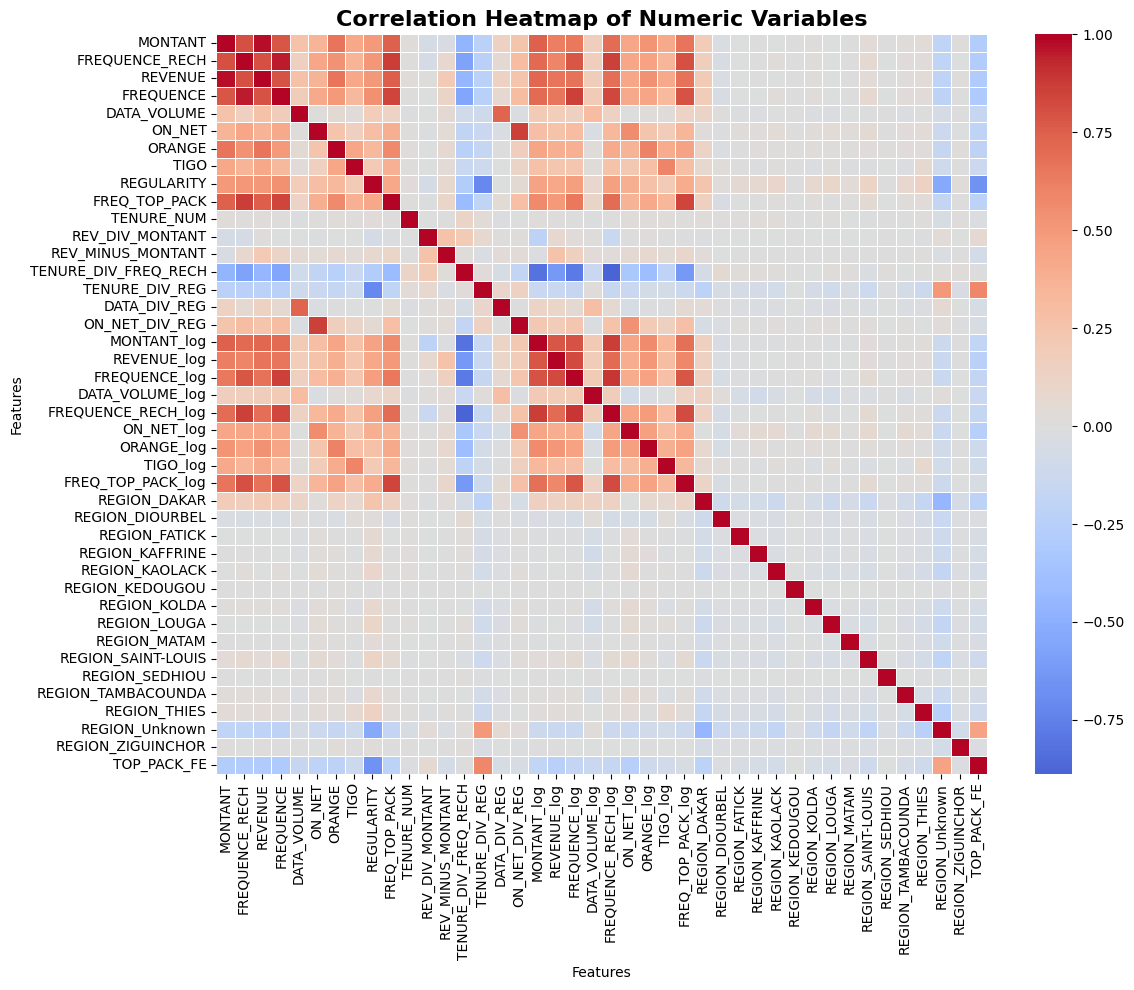

In [59]:
plot_correlation_heatmap(X_train_f)